# Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import torch
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [4]:
DEVICE = torch.device('cuda')

In [5]:
%run ../utils/__init__.py
%run ../models/checkpoint/__init__.py
%run ../utils/nlp.py

In [6]:
config_logging(logging.INFO)

# Load data

In [15]:
%run ../datasets/__init__.py

In [7]:
kwargs = {
    'dataset_name': 'chexpert',
    'dataset_type': 'train-val',
    'batch_size': 45,
    'image_format': 'L',
    'frontal_only': True,
    'norm_by_sample': True,
    'image_size': (1024, 1024),
}

dataloader = prepare_data_classification(**kwargs)
len(dataloader.dataset)

[__main__] INFO(04-06 19:11) Loading chexpert/train-val cl-dataset, bs=45 imgsize=(1024, 1024) version=None format=L n_labels=None
[__main__] INFO(04-06 19:11) 	Dataset size: 191,226


191226

# Load model

In [8]:
run_name = '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'
debug = False

In [9]:
compiled_model = load_compiled_model_segmentation(run_name, debug=debug, device=DEVICE)
compiled_model.metadata

{'model_kwargs': {'model_name': 'scan', 'n_classes': 4},
 'opt_kwargs': {'lr': 0.0005},
 'lr_sch_kwargs': {'mode': 'max',
  'threshold_mode': 'abs',
  'factor': 0.5,
  'patience': 5,
  'verbose': True},
 'hparams': {'loss_weights': [0.1, 0.6, 0.3, 0.3],
  'early_stopping': True,
  'early_stopping_kwargs': {'patience': 20, 'metric': 'iou', 'min_delta': 0},
  'lr_sch_metric': 'iou'},
 'dataset_kwargs': {'dataset_name': 'jsrt',
  'batch_size': 20,
  'image_size': [1024, 1024],
  'num_workers': 2,
  'norm_by_sample': True},
 'dataset_train_kwargs': {'shuffle': None,
  'augment': True,
  'augment_label': None,
  'augment_class': None,
  'augment_times': 10,
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.8,
   'brightness': 0.8,
   'shear': [10, 10]}},
 'run_name': '1202_015907_jsrt_scan_lr0.0005_normS_size1024_wce1-6-3-3_aug10_sch-iou-p5-f0.5'}

# Segment images

And save masks

## Functions

In [10]:
from PIL import Image
from tqdm.notebook import tqdm

In [11]:
%run ../utils/shapes.py

In [12]:
def calculate_output(batch):
    images = batch.image.to(DEVICE)

    with torch.no_grad():
        outputs = compiled_model.model(images).detach().cpu()
        # shape: batch_size, n_labels, height, width

    _, outputs = outputs.max(dim=1)
    # shape: batch_size, height, width

    return outputs

In [13]:
def assertions(mask, image_fname):
    min_value = mask.min()
    if min_value != 0:
        print(f'[{image_fname}] Minimum must be 0, got {min_value}')
    
    max_value = mask.max()
    if max_value != 3:
        print(f'[{image_fname}] Maximum must be 3, got {min_value}')

In [14]:
def get_filepath(masks_folder, image_name):
    filepath = os.path.join(masks_folder, image_name)
    if not filepath.endswith('.png'):
        filepath += '.png'
    return filepath

In [15]:
def clean_image_fname(image_name):
    image_name = image_name.replace('.png', '')
    image_name = image_name.replace('.jpg', '')
    image_name = image_name.replace('/', '-')
    return image_name

## Run segmentation

### Define folders

In [16]:
VERSION = 'v1'
EXIST_OK = True

In [17]:
if dataloader.dataset.__class__.__name__ == 'VinBigDataset':
    FOLDER_NAME = 'organ-masks'
else:
    FOLDER_NAME = 'masks'
FOLDER_NAME

'masks'

In [18]:
masks_folder = os.path.join(dataloader.dataset.dataset_dir, FOLDER_NAME, VERSION)
os.makedirs(masks_folder, exist_ok=EXIST_OK)

### Remove already calculated

Remove already calculated from the dataset, to avoid loading innecessary images from disk

In [19]:
already_calculated = set(
    clean_image_fname(image_name)
    for image_name in os.listdir(masks_folder)
)
len(already_calculated)

56369

In [20]:
if dataloader.dataset.__class__.__name__ in ('ChexpertDataset',):
    ignore_images = set([
        i.replace('-', '/').replace('.png', '.jpg')
        for i in os.listdir(masks_folder)
    ])
    d = dataloader.dataset.label_index
    d = d.loc[~d['Path'].isin(ignore_images)]
    dataloader.dataset.label_index = d.reset_index(drop=True)
    len(dataloader.dataset)

'ChexpertDataset'

### Segment!

In [ ]:
%%capture output
%%time

state = tqdm(total=len(dataloader.dataset))
errors = []

for batch in dataloader:
    if all(
        clean_image_fname(image_name) in already_calculated
        for image_name in batch.image_fname
    ):
        state.update(len(batch.image_fname))
        continue
    
    outputs = calculate_output(batch).cpu()
    
    for image_name, mask in zip(batch.image_fname, outputs):
        image_name = clean_image_fname(image_name)
        if image_name in already_calculated:
            state.update(1)
            continue
            # raise Exception('Overriding previous mask!')

        mask = mask.to(torch.uint8).numpy()
        # shape: height, width
        
        assertions(mask, image_name)
        
        # Keep only largest shape:
        polygons = calculate_polygons(mask)
        largest_polygons = get_largest_shapes(polygons, name=image_name)
        mask = polygons_to_array(largest_polygons, mask.shape)

        assertions(mask, image_name)
        
        if any(len(coords) == 0 for coords, organ_idx in largest_polygons):
            errors.append(image_name)

        # Save to file
        mask = Image.fromarray(mask, mode='L')
        out_fpath = get_filepath(masks_folder, image_name)
        mask.save(out_fpath)

        state.update(1)

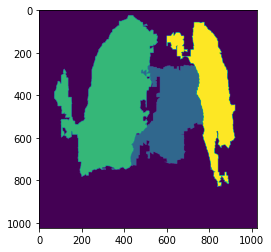

In [35]:
plt.imshow(mask)

### Load errors by name

In [23]:
%run ../utils/images.py

In [16]:
new_kwargs = {
    **kwargs,
    'masks': True,
}
new_dataloader = prepare_data_classification(**new_kwargs)
len(new_dataloader.dataset)

[__main__] INFO(04-06 19:14) Loading chexpert/train-val cl-dataset, bs=45 imgsize=(1024, 1024) version=None format=L n_labels=None
[__main__] INFO(04-06 19:14) 	Dataset size: 191,226


191226

In [17]:
if dataloader.dataset.__class__.__name__ in ('ChexpertDataset',):
    KEY = 'Path'
    image_names = [
        f"{i.replace('-', '/')}.jpg"
        for i in errors
    ]
else:
    KEY = 'FileName'
    image_names = list(errors)
len(image_names)

6

In [18]:
df = new_dataloader.dataset.label_index
rows = df.loc[df[KEY].isin(image_names)]
indexes = list(rows.index)
indexes

[82818, 85623, 89750, 142401, 155090, 165221]

In [ ]:
n_rows = len(indexes)
n_cols = 2

plt.figure(figsize=(n_cols*3, n_rows*3))

for counter, index in enumerate(indexes):
    item = new_dataloader.dataset[index]
    
    row_index = counter * n_cols
    
    plt.subplot(n_rows, n_cols, row_index + 1)
    plt.title(item.image_fname)
    plt.imshow(tensor_to_range01(item.image[0]), cmap='gray')
    
    mask = squeeze_masks(item.masks)
    if mask is not None:
        plt.subplot(n_rows, n_cols, row_index + 2)
        plt.imshow(mask)

#     plt.subplot(1, 2, 2)
#     plt.gca().invert_yaxis()
#     for coords, value in largest_polygons2:
#         if len(coords) == 0:
#             continue
#         x_values, y_values = zip(*coords)
#         plt.plot(x_values, y_values)

# Debug load dataset

## CXR14, IU or alike datasets

In [46]:
%run ../utils/common.py
%run ../utils/images.py

In [ ]:
%run ../datasets/iu_xray.py

dataset = IUXRayDataset('all', image_size=(1024, 1024), frontal_only=True, masks=True)
len(dataset)

In [47]:
%run ../datasets/cxr14.py

dataset = CXR14Dataset('all', image_size=(1024, 1024), frontal_only=True,
                       masks=True, masks_version='v1')
len(dataset)

112120

In [52]:
item = dataset[1]
item.image.size(), item.masks.size(), item.image_fname

(torch.Size([3, 1024, 1024]), torch.Size([4, 1024, 1024]), '00000001_001.png')

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(squeeze_masks(item.masks))
plt.axis('off')

## VinBig alike datasets

In [7]:
import math

In [8]:
%run ../datasets/vinbig.py

dataset = VinBigDataset('train', image_size=(1024, 1024), frontal_only=True,
                        masks=True, fallback_organs=True)
len(dataset)

13500

In [19]:
item = dataset[14]
item.masks.size(), item.labels.shape

(torch.Size([14, 1024, 1024]), (14,))

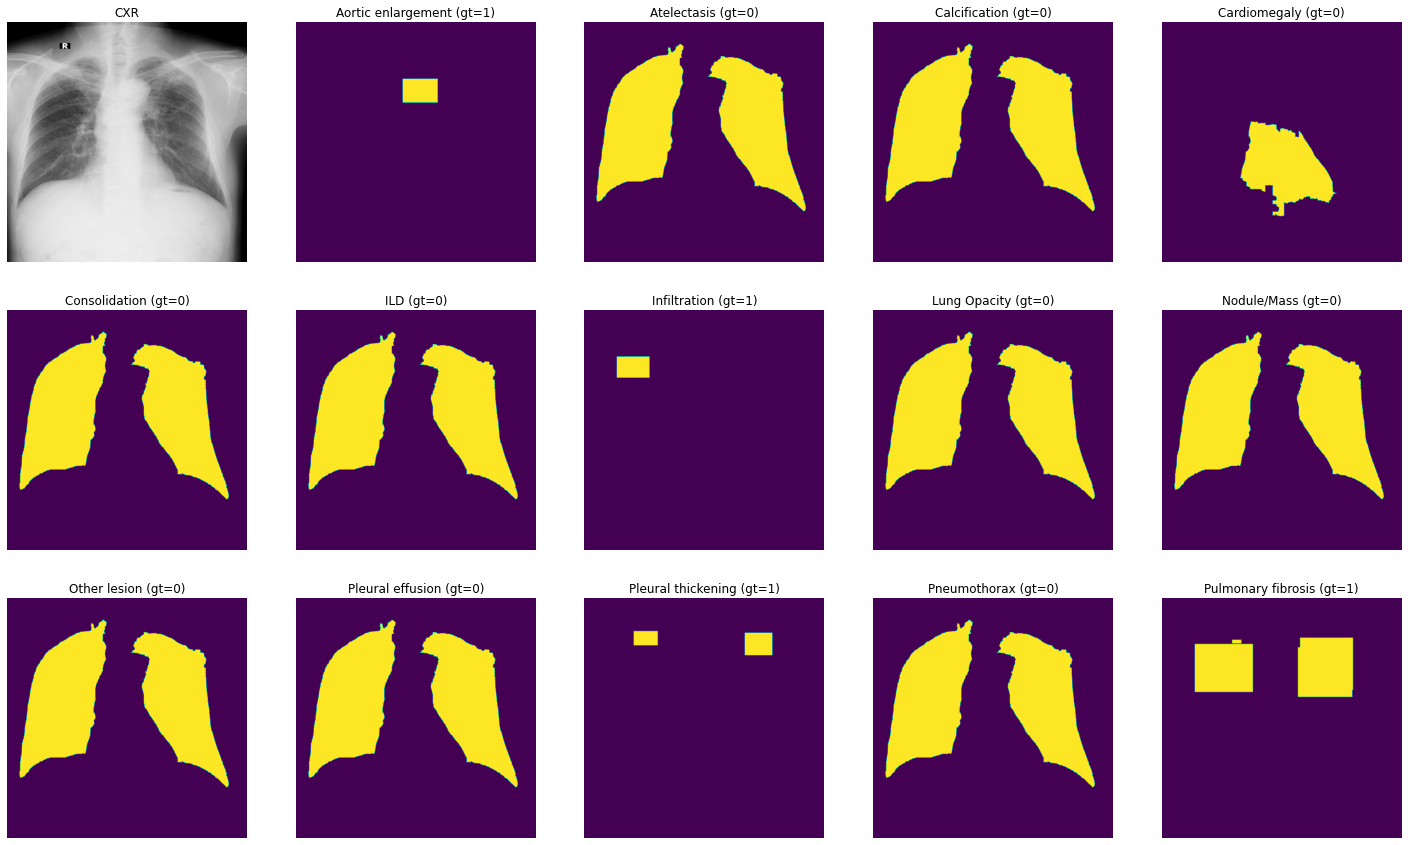

In [20]:
n_plots = len(dataset.labels) + 1

n_rows = 3
n_cols = math.ceil(n_plots / n_rows)

plt.figure(figsize=(n_cols*5, n_rows*5))

plt.subplot(n_rows, n_cols, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.title('CXR')
plt.axis('off')

for disease_i, (disease_name, gt_value) in enumerate(zip(dataset.labels, item.labels)):
    plt.subplot(n_rows, n_cols, disease_i+2)
    plt.imshow(item.masks[disease_i])
    plt.title(f'{disease_name} (gt={gt_value})')
    plt.axis('off')